In [1]:
!date

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as ss
import arviz as az

# Make inline plots raster graphics
from IPython.display import set_matplotlib_formats
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from termcolor import colored

#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('retina')

import seaborn as sns
clrs = sns.color_palette("Spectral", 6)
def set_plot_style(usetex=False):
    sns.set_style('white', {'axes.linewidth': 0.5})
    sns.set(style='white', font_scale=1.1,#context='paper',
            rc={'xtick.major.size': 6, 'ytick.major.size': 6, 'legend.fontsize': 14,
                'text.usetex': usetex, 'font.family': 'serif', 'font.serif': ['Verdana'],
                'text.latex.preamble': r"\usepackage{type1cm}"}) 
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
set_plot_style()
    
import warnings
warnings.filterwarnings('ignore')

func_dict = {"q2.5": lambda x: np.percentile(x, 2.5), 
             "q25": lambda x: np.percentile(x, 25), 
             "median": lambda x: np.percentile(x, 50), 
             "q75": lambda x: np.percentile(x, 75), 
             "q97.5": lambda x: np.percentile(x, 97.5)}

!mkdir -p ../../results/Andrei/Stan-sims

def get_stats(cmdstan_data):
    # include mean and hpd
    stats = az.summary(cmdstan_data,credible_interval=0.95).loc[:, ['mean','hpd_2.5%','hpd_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hpd_2.5%':'hpd2.5', 'hpd_97.5%':'hpd97.5'})
    stats = az.summary(cmdstan_data,credible_interval=0.50).loc[:, ['hpd_25%','hpd_75%']].reset_index().rename(columns={'index':'var', 'hpd_25%':'hpd25', 'hpd_75%':'hpd75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, stat_funcs=func_dict, extend=False).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else int(x)+1 for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hpd2.5','hpd25','hpd75','hpd97.5','q2.5','q25','median','q75','q97.5','ess_bulk','ess_tail','r_hat']]

In [3]:
dirs = !ls -d stan-sims/*
dirs

['stan-sims/gamma-no_truncation',
 'stan-sims/gamma-truncated',
 'stan-sims/lognormal-no_truncation',
 'stan-sims/lognormal-truncated',
 'stan-sims/lognormal-truncated_tmp',
 'stan-sims/weibull-no_truncation',
 'stan-sims/weibull-truncated']

In [4]:
distribs = np.unique([folder.split("/")[-1].split("-")[0] for folder in dirs])
distribs

array(['gamma', 'lognormal', 'weibull'], dtype='<U9')

In [5]:
truncations = np.unique([folder.split("/")[-1].split("-")[1] for folder in dirs])
truncations

array(['no_truncation', 'truncated', 'truncated_tmp'], dtype='<U13')

# No truncation

lognormal-no_truncation


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.540,0.523,3.557,5.588,0.002,0.001,86768.0,81018.0,94809.0,64441.0,1.0
sd_SI,2.231,0.589,1.286,3.374,0.002,0.002,72376.0,60868.0,94921.0,60418.0,1.0
param1,1.397,0.114,1.173,1.620,0.000,0.000,105060.0,105060.0,106243.0,78144.0,1.0
param2,0.461,0.083,0.314,0.627,0.000,0.000,93527.0,84616.0,106155.0,71567.0,1.0


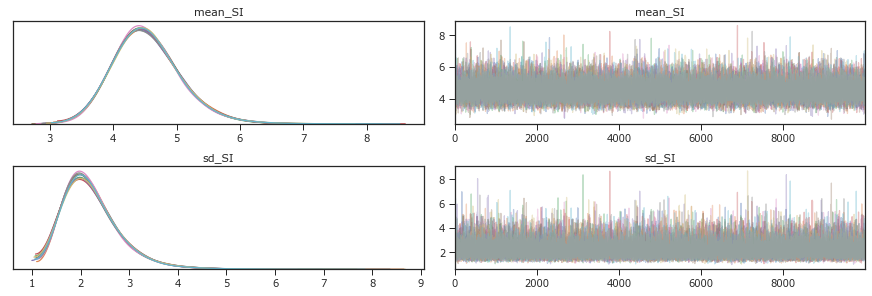

In [6]:
folder = "lognormal-no_truncation"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))

posterior_glob = !ls stan-sims/{folder}/trace-*

cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data)  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
plt.savefig("../../results/Andrei/Stan-sims/traceplots/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data,credible_interval=0.95,var_names=['mean_SI','sd_SI','param1','param2'])

gamma-no_truncation


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.772,0.578,3.687,5.933,0.002,0.001,84616.0,79233.0,92421.0,64267.0,1.0
sd_SI,2.317,0.540,1.433,3.399,0.002,0.001,76533.0,66088.0,96539.0,62593.0,1.0
param1,4.673,1.649,1.777,7.929,0.005,0.003,125306.0,119901.0,118517.0,76914.0,1.0
param2,0.994,0.370,0.357,1.738,0.001,0.001,113916.0,113916.0,103461.0,71103.0,1.0


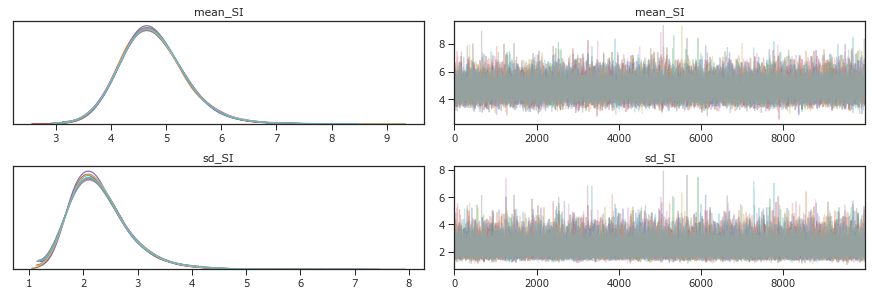

In [7]:
folder = "gamma-no_truncation"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))

posterior_glob = !ls stan-sims/{folder}/trace-*

cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data)  

az.plot_trace(cmdstan_data, var_names = ['mean_SI','sd_SI']);
plt.savefig("../../results/Andrei/Stan-sims/traceplots/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data, credible_interval=0.95, var_names = ['mean_SI','sd_SI','param1','param2'])

weibull-no_truncation


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.782,0.557,3.696,5.872,0.002,0.001,96184.0,92803.0,98875.0,72018.0,1.0
sd_SI,2.250,0.446,1.552,3.126,0.002,0.001,78792.0,65236.0,118597.0,62444.0,1.0
param1,2.318,0.436,1.508,3.201,0.001,0.001,104644.0,104644.0,102055.0,71773.0,1.0
param2,5.378,0.624,4.165,6.615,0.002,0.001,97268.0,94579.0,99364.0,71867.0,1.0


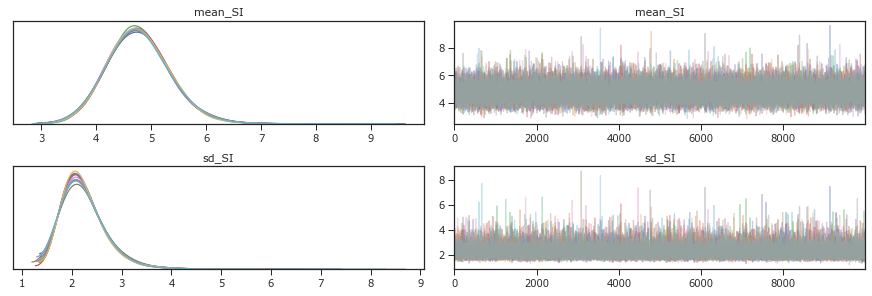

In [8]:
folder = "weibull-no_truncation"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))

posterior_glob = !ls stan-sims/{folder}/trace-*

cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data)  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
plt.savefig("../../results/Andrei/Stan-sims/traceplots/trace-"+folder+".pdf", format='pdf')
az.summary(cmdstan_data, credible_interval=0.95, var_names=['mean_SI','sd_SI','param1','param2'])

## Comparing different models

In [9]:
!mkdir -p ../../results/Andrei/Stan-sims/traceplots
for truncation_type in ['no_truncation']:
    for idx, distrib in enumerate(distribs):
        folder = distrib+"-"+truncation_type
        print(colored(folder, 'red'))

        posterior_glob = !ls stan-sims/{folder}/trace-*

        cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
        param1 = cmdstan_data.posterior.param1.values.ravel()
        param2 = cmdstan_data.posterior.param2.values.ravel()
        cmdstan_stats = get_stats(cmdstan_data)  

        df_ = cmdstan_stats
        meanSI_ = df_.loc[lambda d: d['var']=='mean_SI',['mean','q2.5','q97.5']].values[0]
        sdSI_ = df_.loc[lambda d: d['var']=='sd_SI',['mean','q2.5','q97.5']].values[0]

        if distrib=='gamma':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
            y = np.percentile(np.stack([ss.gamma(param1[idx],scale=1/param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='weibull':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.weibull_min.html
            y = np.percentile(np.stack([ss.weibull_min(param1[idx],scale=param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='lognormal':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
            y = np.percentile(np.stack([ss.lognorm(param2[idx],scale=np.exp(param1[idx])).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        output_ = [distrib,truncation_type,
              '%.1f (%.1f, %.1f)'%(meanSI_[0],meanSI_[1],meanSI_[2]),
              '%.1f (%.1f, %.1f)'%(sdSI_[0],sdSI_[1],sdSI_[2]),
              '%.1f (%.1f, %.1f)'%(y[:,0][0],y[:,0][1],y[:,0][2]),
              '%.1f (%.1f, %.1f)'%(y[:,1][0],y[:,1][1],y[:,1][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,2][0],y[:,2][1],y[:,2][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,3][0],y[:,3][1],y[:,3][2])]

        output = [output_] if idx==0 else np.r_[output, [output_]]
        print(output_)
        cmdstan_data_all = [cmdstan_data] if idx==0 else np.r_[cmdstan_data_all, cmdstan_data]


    output_df = pd.DataFrame(output,
                             columns=['Distribution', 'Truncation', 'mean', 
                                      'SD', 'q5', 'median', 'q95', 'q99'])

    models = dict([[distribs[idx], cmdstan_data_all[idx]] for idx in range(len(output))])
    stats_compare = az.compare(models, method='stacking')

    df_stats_compare = stats_compare.reset_index().rename(columns={'index': 'Distribution'})
    df_stats_compare = df_stats_compare.loc[:,['Distribution','waic','d_waic','weight']]

    Df_ = df_stats_compare.merge(output_df)
    Df_['waic'] = [round(x,1) for x in Df_['waic']]
    Df_['d_waic'] = [round(x,2) for x in Df_['d_waic']]
    Df_['weight'] = [round(x,3) for x in Df_['weight']]
    display(Df_)

Df_.to_excel('../../results/Andrei/Stan-sims/summary-'+truncation_type+'.xlsx')

gamma-no_truncation
['gamma', 'no_truncation', '4.8 (3.8, 6.1)', '2.3 (1.5, 3.6)', '1.7 (0.9, 2.5)', '4.4 (3.4, 5.5)', '8.9 (6.9, 12.6)', '11.4 (8.6, 17.1)']
lognormal-no_truncation
['lognormal', 'no_truncation', '4.5 (3.6, 5.7)', '2.2 (1.4, 3.7)', '1.9 (1.2, 2.6)', '4.1 (3.2, 5.0)', '8.5 (6.6, 12.3)', '11.6 (8.5, 18.6)']
weibull-no_truncation
['weibull', 'no_truncation', '4.8 (3.8, 6.0)', '2.2 (1.6, 3.3)', '1.5 (0.7, 2.3)', '4.6 (3.4, 5.7)', '8.6 (7.0, 11.8)', '10.4 (8.3, 15.3)']


,Distribution,waic,d_waic,weight,Truncation,mean,SD,q5,median,q95,q99
0,lognormal,77.6,0.00,1.0,no_truncation,"4.5 (3.6, 5.7)","2.2 (1.4, 3.7)","1.9 (1.2, 2.6)","4.1 (3.2, 5.0)","8.5 (6.6, 12.3)","11.6 (8.5, 18.6)"
1,gamma,78.6,1.07,0.0,no_truncation,"4.8 (3.8, 6.1)","2.3 (1.5, 3.6)","1.7 (0.9, 2.5)","4.4 (3.4, 5.5)","8.9 (6.9, 12.6)","11.4 (8.6, 17.1)"
2,weibull,80.2,2.68,0.0,no_truncation,"4.8 (3.8, 6.0)","2.2 (1.6, 3.3)","1.5 (0.7, 2.3)","4.6 (3.4, 5.7)","8.6 (7.0, 11.8)","10.4 (8.3, 15.3)"


# With truncation

lognormal-truncated


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.590,0.558,3.567,5.707,0.002,0.002,69913.0,63566.0,81300.0,57201.0,1.0
sd_SI,2.293,0.659,1.283,3.546,0.003,0.002,57568.0,46711.0,82742.0,55323.0,1.0
param1,1.404,0.116,1.172,1.629,0.000,0.000,95739.0,94769.0,96270.0,73302.0,1.0
param2,0.466,0.086,0.314,0.641,0.000,0.000,83916.0,75459.0,97426.0,67969.0,1.0


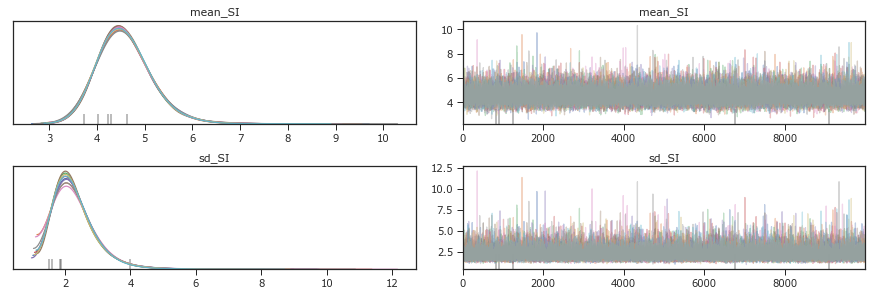

In [10]:
folder = "lognormal-truncated"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))

posterior_glob = !ls stan-sims/{folder}/trace-*

cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data)  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
az.summary(cmdstan_data,credible_interval=0.95,var_names=['mean_SI','sd_SI','param1','param2'])

gamma-truncated


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.837,0.626,3.731,6.114,0.002,0.002,70314.0,62410.0,84648.0,55316.0,1.0
sd_SI,2.380,0.617,1.429,3.574,0.003,0.002,60716.0,48955.0,86497.0,56695.0,1.0
param1,4.595,1.652,1.695,7.875,0.005,0.003,114635.0,113287.0,106126.0,75131.0,1.0
param2,0.969,0.373,0.308,1.708,0.001,0.001,104306.0,104306.0,91855.0,62810.0,1.0


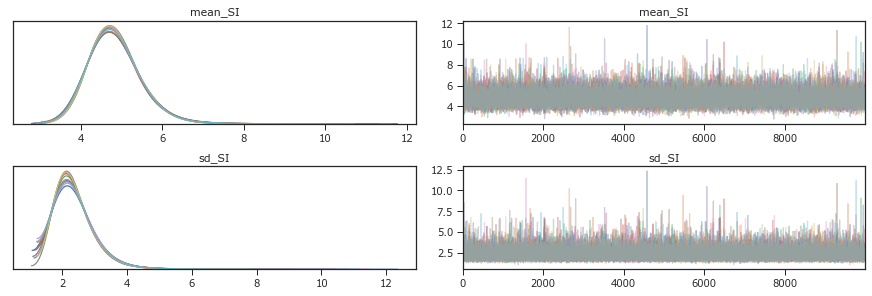

In [11]:
folder = "gamma-truncated"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))

posterior_glob = !ls stan-sims/{folder}/trace-*

cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data)  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
az.summary(cmdstan_data,credible_interval=0.95,var_names=['mean_SI','sd_SI','param1','param2'])

weibull-truncated


,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mean_SI,4.848,0.610,3.743,6.035,0.002,0.002,59867.0,41711.0,88301.0,56842.0,1.0
sd_SI,2.301,0.545,1.539,3.243,0.003,0.003,37609.0,22480.0,97915.0,50454.0,1.0
param1,2.305,0.439,1.454,3.165,0.001,0.001,94226.0,94226.0,90755.0,65730.0,1.0
param2,5.452,0.674,4.212,6.788,0.003,0.002,67708.0,52447.0,89178.0,57768.0,1.0


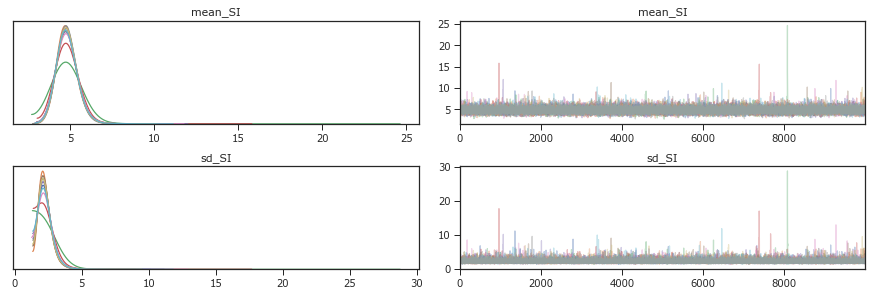

In [12]:
folder = "weibull-truncated"
distrib, truncation_type = folder.split("-")

print(colored(folder, 'red'))

posterior_glob = !ls stan-sims/{folder}/trace-*

cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
cmdstan_stats = get_stats(cmdstan_data)  

az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
az.summary(cmdstan_data,credible_interval=0.95,var_names=['mean_SI','sd_SI','param1','param2'])

gamma-truncated
['gamma', 'truncated', '4.8 (3.8, 6.2)', '2.4 (1.5, 3.9)', '1.7 (0.8, 2.5)', '4.4 (3.4, 5.7)', '9.0 (7.0, 13.4)', '11.5 (8.6, 18.4)']
lognormal-truncated
['lognormal', 'truncated', '4.6 (3.7, 5.8)', '2.3 (1.4, 3.9)', '1.9 (1.2, 2.6)', '4.1 (3.2, 5.1)', '8.6 (6.6, 13.1)', '11.7 (8.5, 20.2)']
weibull-truncated
['weibull', 'truncated', '4.8 (3.8, 6.1)', '2.3 (1.6, 3.5)', '1.5 (0.7, 2.4)', '4.6 (3.5, 5.9)', '8.7 (7.1, 12.5)', '10.5 (8.4, 16.1)']


,Distribution,waic,d_waic,weight,Truncation,mean,SD,q5,median,q95,q99
0,weibull,122.1,0.00,1.0,truncated,"4.8 (3.8, 6.1)","2.3 (1.6, 3.5)","1.5 (0.7, 2.4)","4.6 (3.5, 5.9)","8.7 (7.1, 12.5)","10.5 (8.4, 16.1)"
1,lognormal,138.8,16.75,0.0,truncated,"4.6 (3.7, 5.8)","2.3 (1.4, 3.9)","1.9 (1.2, 2.6)","4.1 (3.2, 5.1)","8.6 (6.6, 13.1)","11.7 (8.5, 20.2)"
2,gamma,140.0,17.92,0.0,truncated,"4.8 (3.8, 6.2)","2.4 (1.5, 3.9)","1.7 (0.8, 2.5)","4.4 (3.4, 5.7)","9.0 (7.0, 13.4)","11.5 (8.6, 18.4)"


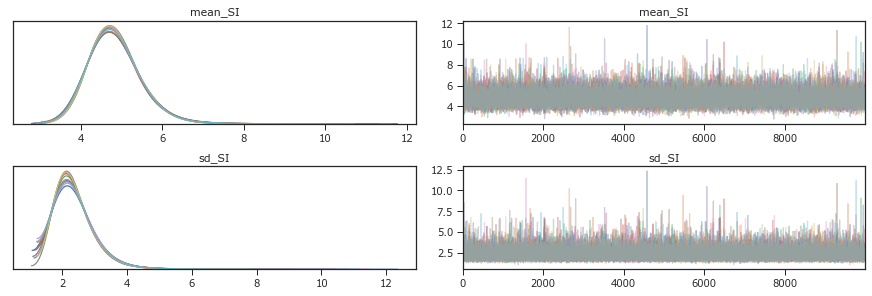

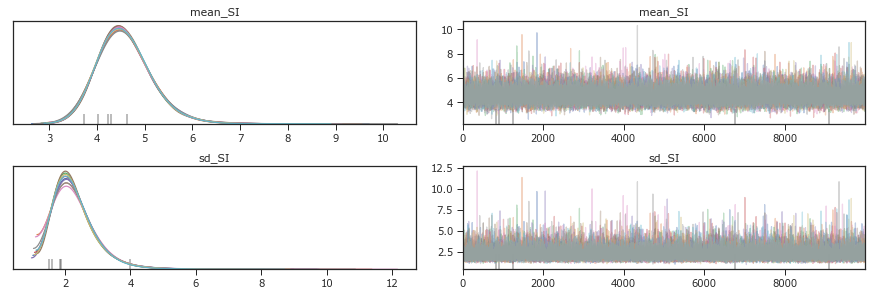

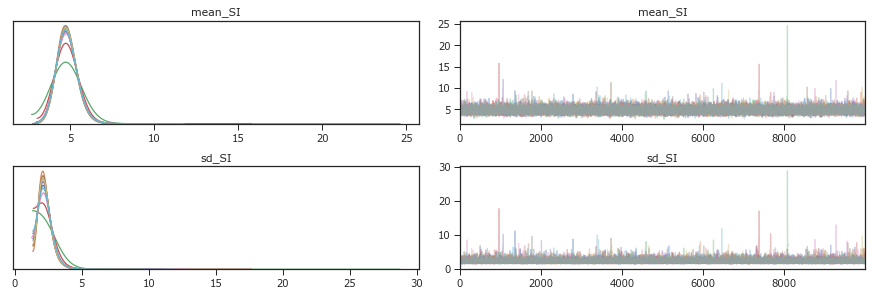

In [13]:
!mkdir -p ../../results/Andrei/Stan-sims/traceplots
for truncation_type in ['truncated']:
    for idx, distrib in enumerate(distribs):
        folder = distrib+"-"+truncation_type
        print(colored(folder, 'red'))

        posterior_glob = !ls stan-sims/{folder}/trace-*

        cmdstan_data = az.from_cmdstan(posterior = posterior_glob, log_likelihood="log_likelihood")
        param1 = cmdstan_data.posterior.param1.values.ravel()
        param2 = cmdstan_data.posterior.param2.values.ravel()
        cmdstan_stats = get_stats(cmdstan_data)  

        df_ = cmdstan_stats
        meanSI_ = df_.loc[lambda d: d['var']=='mean_SI',['mean','q2.5','q97.5']].values[0]
        sdSI_ = df_.loc[lambda d: d['var']=='sd_SI',['mean','q2.5','q97.5']].values[0]

        if distrib=='gamma':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html
            y = np.percentile(np.stack([ss.gamma(param1[idx],scale=1/param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='weibull':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.weibull_min.html
            y = np.percentile(np.stack([ss.weibull_min(param1[idx],scale=param2[idx]).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        elif distrib=='lognormal':
            # see https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.lognorm.html
            y = np.percentile(np.stack([ss.lognorm(param2[idx],scale=np.exp(param1[idx])).ppf([.05,.5,.95,.99]).tolist() for idx in range(10000)]).T,[50,2.5,97.5],axis=1)
        output_ = [distrib,truncation_type,
              '%.1f (%.1f, %.1f)'%(meanSI_[0],meanSI_[1],meanSI_[2]),
              '%.1f (%.1f, %.1f)'%(sdSI_[0],sdSI_[1],sdSI_[2]),
              '%.1f (%.1f, %.1f)'%(y[:,0][0],y[:,0][1],y[:,0][2]),
              '%.1f (%.1f, %.1f)'%(y[:,1][0],y[:,1][1],y[:,1][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,2][0],y[:,2][1],y[:,2][2]), 
              '%.1f (%.1f, %.1f)'%(y[:,3][0],y[:,3][1],y[:,3][2])]

        output = [output_] if idx==0 else np.r_[output, [output_]]
        print(output_)
        cmdstan_data_all = [cmdstan_data] if idx==0 else np.r_[cmdstan_data_all, cmdstan_data]

        az.plot_trace(cmdstan_data, var_names=['mean_SI','sd_SI']);
        plt.savefig("../../results/Andrei/Stan-sims/traceplots/trace-"+folder+".pdf", format='pdf')

    output_df = pd.DataFrame(output,
                             columns=['Distribution', 'Truncation', 'mean', 
                                      'SD', 'q5', 'median', 'q95', 'q99'])

    models = dict([[distribs[idx], cmdstan_data_all[idx]] for idx in range(len(output))])
    stats_compare = az.compare(models, method='stacking')

    df_stats_compare = stats_compare.reset_index().rename(columns={'index': 'Distribution'})
    df_stats_compare = df_stats_compare.loc[:,['Distribution','waic','d_waic','weight']]

    Df_ = df_stats_compare.merge(output_df)
    Df_['waic'] = [round(x,1) for x in Df_['waic']]
    Df_['d_waic'] = [round(x,2) for x in Df_['d_waic']]
    Df_['weight'] = [round(x,3) for x in Df_['weight']]
    display(Df_)

Df_.to_excel('../../results/Andrei/Stan-sims/summary-'+truncation_type+'.xlsx')